<h2> Goal 1: Implementation of the Schwartz one-factor model </h2>

<h3> a) Implement the Schwartz one-factor model. Plot the spot price $S_t$ as well as the
convenience yield $y_t$
for t ∈ [0, T]. </h3>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.matlib

from scipy.stats import norm

from scipy import optimize,stats

The goal of this TP is to investigate the properties of the Schwartz one-factor model. Recall from the lecture that the $\mathbb P$-dynamics of the spot price is

$$
dS_t = \kappa (\mu - \log S_t) S_t dt + \sigma S_t dW^{\mathbb P}_t,
$$

where $W^{\mathbb P}_t$ is a Brownian motion under the historical measure $\mathbb P$. Here $\kappa > 0$, $\mu \in \mathbb R$, and $\sigma > 0$ are parameters. The $\mathbb Q$-dynamics of the spot price is

$$
dS_t = \kappa (\mu - \lambda - \log S_t) S_t dt + \sigma S_t dW^{\mathbb Q}_t,
$$

where $W^{\mathbb Q}_t = W^{\mathbb P}_t + \frac{\kappa \lambda}{\sigma} t$ is a Brownian motion under the risk-neutral measure $\mathbb Q$. Here $\lambda$ is a market price of risk parameter. Since the $\mathbb Q$-drift is always equal to $(r - y_t) S_t dt$ where $y_t$ is the convenience yield, it follows that

$$
y_t = r - \kappa (\mu - \lambda) + \kappa \log S_t.
$$

We use the parameter values given in TP5, defned as:

$$
\kappa = 0.3 \qquad \mu = 3.1 \qquad \sigma = 0.4 \qquad \lambda = -0.2 \qquad T = 2
$$

and start the spot price at $S_0 = 19$.

In [3]:
kappa = 0.3
mu = 3.1
sigma = 0.4
lam = -0.2
T=2

S0 = 19

In [4]:
def sim_W(T,N):
    dt = T/N # size of the intervals
    times = dt*np.arange(0,N+1) # grid of times t_0,...,t_N
    dW = np.sqrt(dt)*np.random.randn(N) # dW is a vector containing the ind. increments over the grid
    W = np.cumsum(dW) # cumulative sum: W = [dW[0], dW[0]+dW[1], dW[0]+dW[1]+dW[2], ..., dW[0]+...+dW[N-1]]
    W = np.insert(W, 0, 0) # include zero; we want W[0] = 0
    return [times,W]

In [5]:
def sim_Schwartz(T,N,S0,kappa,mu,sigma):
    dt = T/N
    [times,W] = sim_W(T,N) # construct grid and simulate Brownian motion
    S = np.zeros(N+1)
    S[0] = S0
    for i in range(N):
        S[i+1]= S[i] + kappa*(mu-np.log(S[i]))*S[i]*dt + sigma*S[i]*(W[i+1]-W[i])
    return [times,S]

In [6]:
def sim_ConvYield(T,N,S0,kappa,mu,sigma,S):
  y = np.zeros(N+1)
  r=0.05
  for i in range(N+1):
        y[i]= r - kappa*(mu-lam) + kappa*np.log(S[i])
  return y

In [7]:
T = 2
N = 500

[times,S] = sim_Schwartz(T,N,S0,kappa,mu,sigma)
y = sim_ConvYield(T,N,S0,kappa,mu,sigma,S)

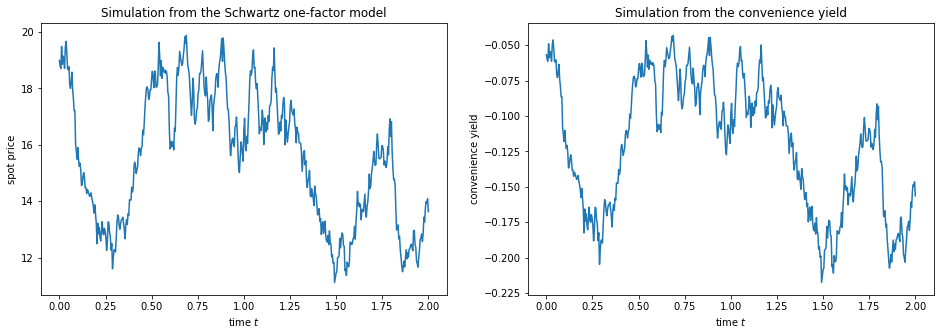

In [8]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(16,5))

ax1.plot(times, S)
ax1.set(title='Simulation from the Schwartz one-factor model', 
        xlabel='time $t$', ylabel='spot price')

ax2.plot(times, y)
ax2.set(title='Simulation from the convenience yield', 
        xlabel='time $t$', ylabel='convenience yield')

plt.show()

<h3> b) Plot the corresponding futures prices in the same figure as the spot price.
Comment on the behavior. </h3>


In [9]:
# Note that the futures price depends on t,T only through time to maturity tau = T-t.
# t takes the values t_i = i*(T/N)
# We therefore use a single argument tau instead of two arguments N,T for each i
def futures_Schwartz_i(S,tau,kappa,mu,sigma,lam):
    alpha_star = mu - (sigma**2)/(2*kappa) - lam
    #tau=T-i*(T/N)
    return np.exp( np.exp(-kappa*tau) * np.log(S) + (1 - np.exp(-kappa*tau))*alpha_star 
                  + ((sigma**2)/(4*kappa))*(1 - np.exp(-2*kappa*tau)) )

def futures_Schwartz(S,T,N,kappa,mu,sigma,lam):
  F = np.zeros(N+1)
  for i in range(N+1):
        tau=T-i*(T/N)
        F[i]= futures_Schwartz_i(S[i],tau,kappa,mu,sigma,lam)
  return F

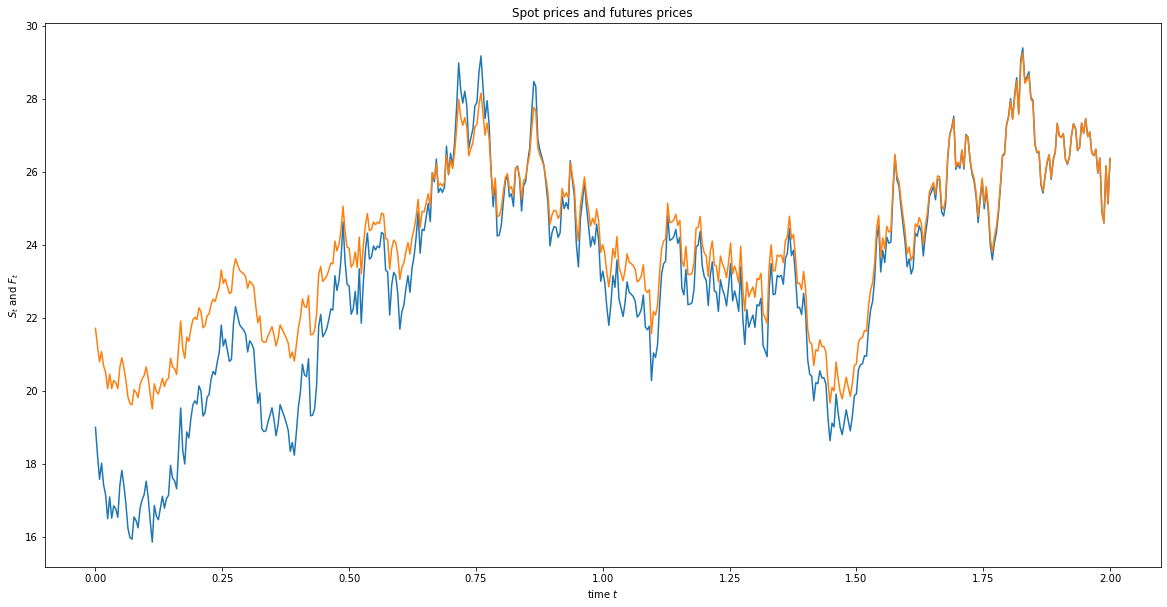

In [10]:
# We replot the Spot price and Future price on the same figure:

N = 500 # number of time steps in the simulation

[times,S] = sim_Schwartz(T,N,S0,kappa,mu,sigma)
F = futures_Schwartz(S,T,N,kappa,mu,sigma,lam)

plt.figure(figsize=(20,10))
plt.plot(times,S)
plt.plot(times,F)

plt.title('Spot prices and futures prices')
plt.xlabel('time $t$')
plt.ylabel('$S_t$ and $F_t$')

plt.show()

As shown in the figure above the Spot and Future prices have the same fluctuations as they are fully correlated ($Δ$ = 1).
We notice as well that spread between the Spot and the Future prices decrease gradually until both prices are equal at $t \approx T$ ($\tau  \approx 0 $)

<h3> c) Plot the term structure of futures prices, and show how it changes over time. </h3>

We consider five equally spaced time points $t_0,\ldots,t_4$ in $[0,T_1]$. Thus $t_i = iT_1/4$ for $i = 0,\ldots,4$. For each $t_i$, plot the corresponding futures price term structure $F(t_i,t_i + \tau)$ as $\tau$ ranges from $0$ to $1$. More precisely, for each $i$ plot

$$
(t_i+\tau, F(t_i,t_i+\tau)), \quad \tau \in [0,1]
$$

in the same figure where $S_t$ was plotted in (a). You should see the futures term structure emanating from the spot price at each of the time points $t_i$.

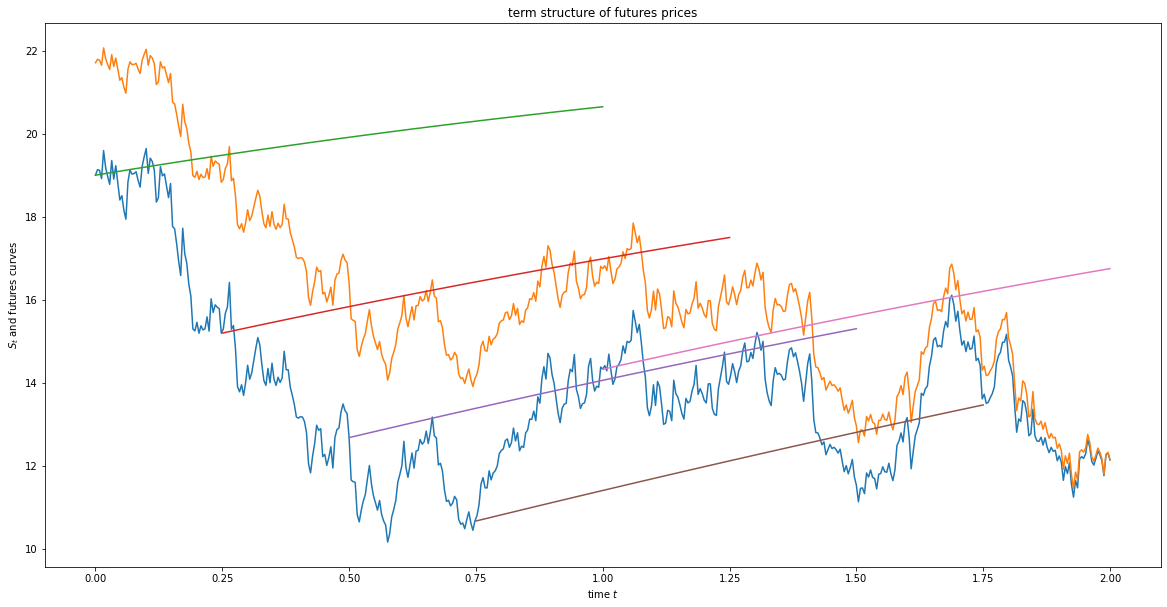

In [11]:
# We plot the term structures (in the same figure):
[times,S] = sim_Schwartz(T,N,S0,kappa,mu,sigma)
F = futures_Schwartz(S,T,N,kappa,mu,sigma,lam)

plt.figure(figsize=(20,10))
plt.plot(times,S)
plt.plot(times,F)

plt.title('Spot prices, futures prices and term structure of futures prices')
plt.xlabel('time $t$')
plt.ylabel('$S_t$ and $F_t$')
tau = np.linspace(0, 1, 30)
T1=1
for i in range(5):
    ti = i*T1/4 # time at which to start plotting the term structure
    ti_idx = int(ti * N / T) # index of the time ti
    F = futures_Schwartz_i(S[ti_idx],tau,kappa,mu,sigma,lam)
    plt.plot(ti + tau, F)

plt.title('term structure of futures prices')
plt.xlabel('time $t$')
plt.ylabel('$S_t$ and futures curves')

plt.show()

<h1> Project Goal 2 </h1>

In [13]:
#[times,S] = sim_Schwartz(T,N,S0,kappa,mu,sigma)
#[a, eta_square] = expectation_variance_Schwartz(S,T,N,kappa,mu,sigma,lam)
K = 20
r = 2.6 / 1.5

In [12]:
def option_price_Schwartz(r, S,T,N,kappa,mu,sigma,lam, K, T_1_index):
    C = np.zeros(N+1)
    T_1 = T_1_index*(T/N)
    alpha_star = mu - (sigma**2)/(2*kappa) - lam
    for j in range(T_1_index):
        tau = T_1 - j*(T/N)
        a = np.exp(-kappa*(T-T_1))*(np.exp(-kappa*tau)*np.log(S[i]) + (1 - np.exp(-kappa*tau))*alpha_star) + (1 - np.exp(-kappa*(T-T_1)))*alpha_star + ((sigma**2)/(4*kappa))*(1 - np.exp(-2*kappa*(T-T_1)))
        eta_square = np.exp(-2*kappa*tau)*(((sigma**2)/(2*kappa))*(1 - np.exp(-2*kappa*tau)))
        d_2 = (1/np.sqrt(eta_square))*(a - np.log(K))
        d_1 = np.sqrt(eta_square) + d_2
        C[j] = np.exp(-r*T_1)*(np.exp(a + eta_square/2)*norm.cdf(d_1) - K*norm.cdf(d_2))
    return C

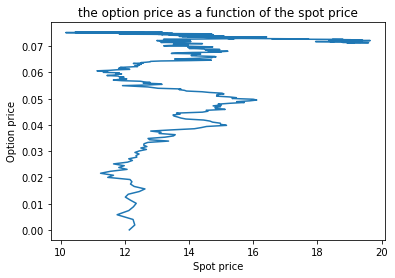

In [14]:
T_1_index = 500
T_1  = T_1_index*(T/N)

#(((sigma**2)/(2*kappa))*(1 - np.exp(-2*kappa*tau)))
C = option_price_Schwartz(r, S,T,N,kappa,mu,sigma,lam, K, T_1_index)
plt.plot(S,C)
plt.title('the option price as a function of the spot price')
plt.xlabel('Spot price')
plt.ylabel('Option price')

plt.show()